# AI-based spinal stenosis segmentation
## Datasets
### 1. Lumbar Spine MRI
This data set contains anonymised clinical MRI study, or a set of scans, of 90-100 patients with symptomatic back pains. Each patient data can have one or more MRI studies associated with it.  Each study contains slices, i.e., axial view, of the lowest three vertebrae and the lowest three IVDs. The axial view slices are mainly taken from the last three IVDs – including the one between the last vertebrae and the sacrum. The orientation of the slices of the last IVD are made to follow the spine curve whereas those of the other IVDs are usually made in blocks – i.e., parallel to each other. There are between four to five slices per IVD and they begin from the top of the IVD towards its bottom. Many of the top and bottom slices cut through the vertebrae leaving between one to three slices that cut the IVD cleanly and show purely the image of that IVD. In most cases, the total number of slices in axial view ranges from 12 to 15. However, in some cases, there may be up to 20 slices because the study contains slices of more than last three vertebrae.

### 2. Ground Truth Labels Data
We have accessed datasets of "lumbar spine MRI" from mendely datasets. This dataset contains the raw label images and ground truth label images of axial view slices of lumbar spine MRI used to train SegNet to detect lumbar spinal stenosis. The four labelled Regions of Interest namely 1) Intervertebral Disc (IVD), 2) Posterior Element (PE), 3) Thecal Sac (TS) and 4) the Area between Anterior and Posterior (AAP) vertebrae elements.

In [ ]:
#Dataset is in drive so
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install pydicom
"""!pip install matplotlib
!pip install numpy
!pip install opencv-python-headless"""


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.9 MB/s eta 0:00:00


'!pip install matplotlib\n!pip install numpy\n!pip install opencv-python-headless'

In [ ]:
!pip install SimpleITK

In [ ]:
!pip install SimpleITK

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import cv2
#import pydicom
from glob import glob
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

Checking the paths of datasets in google drive if they are correct.

In [ ]:
!ls "/content/drive/My Drive/MRI_data"

In [ ]:
# Define paths
MRI_PATH = "/content/drive/MyDrive/MRI_data"
LABELS_PATH = "/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images"

# Get patient folders in MRI data
mri_patients = sorted(os.listdir(MRI_PATH))  # ['0001', '0002', ..., '0100']

# Get patient IDs from label files
label_files = sorted(os.listdir(LABELS_PATH))  # ['L1_0001_D3', 'L1_0001_D4', ...]

# Extract unique patient IDs from labels
label_patient_ids = sorted(set(f.split("_")[1] for f in label_files))  # ['0001', '0002', ..., '0100']

# Check if they match
print("MRI Patients:", mri_patients[:5])
print("Label Patients:", label_patient_ids[:5])

# Verify total count
print(f"Total MRI Patients: {len(mri_patients)}, Total Label Patients: {len(label_patient_ids)}")


MRI Patients: ['0001', '0002', '0003', '0004', '0005']
Label Patients: ['0001', '0002', '0003', '0004', '0005']
Total MRI Patients: 92, Total Label Patients: 92


In [ ]:
import os

# Define the MRI root path
MRI_PATH = "/content/drive/MyDrive/MRI_data"

# List all patient folders in the MRI data path
patient_folders = [folder for folder in os.listdir(MRI_PATH) if os.path.isdir(os.path.join(MRI_PATH, folder))]

# Subfolder names to check (e.g., T1_TSE_TRA_0005, T1_TSE_TRA_0006, etc.)
subfolder_names = [
    "T1_TSE_TRA_0005", "T1_TSE_TRA_0006", "T1_TSE_TRA_0007",
    "T1_TSE_TRA_0008", "T1_TSE_TRA_0004"
]

# Initialize a dictionary to count the number of occurrences for each subfolder
subfolder_counts = {subfolder_name: 0 for subfolder_name in subfolder_names}

# Loop through each patient folder
for patient_folder in patient_folders:
    # Get all subfolders inside the patient folder
    patient_subfolders = [subfolder for subfolder in os.listdir(os.path.join(MRI_PATH, patient_folder))
                          if os.path.isdir(os.path.join(MRI_PATH, patient_folder, subfolder))]

    # Now, check for the presence of any of the subfolder names inside the subfolders
    for subfolder in patient_subfolders:
        for subfolder_name in subfolder_names:
            subfolder_path = os.path.join(MRI_PATH, patient_folder, subfolder, subfolder_name)

            if os.path.isdir(subfolder_path):
                subfolder_counts[subfolder_name] += 1
                print(f"✅ '{subfolder_name}' found in {patient_folder}/{subfolder}")
                break

# Print the counts for each subfolder
print("\n--- Summary of Subfolder Occurrences ---")
for subfolder_name, count in subfolder_counts.items():
    print(f"'{subfolder_name}' found in {count} patient folders")


✅ 'T1_TSE_TRA_0005' found in 0096/L-SPINE_LSS_20151117_131329_832000
✅ 'T1_TSE_TRA_0005' found in 0094/L-SPINE_CLINICAL_LIBRARIES_20160424_153731_325000
✅ 'T1_TSE_TRA_0005' found in 0098/L-SPINE_LSS_20160328_132004_626000
✅ 'T1_TSE_TRA_0005' found in 0099/L-SPINE_LSS_20160208_112224_396000
✅ 'T1_TSE_TRA_0005' found in 0095/L-SPINE_LSS_20151107_131650_426000
✅ 'T1_TSE_TRA_0005' found in 0092/L-SPINE_LSS_20160331_135408_645000
✅ 'T1_TSE_TRA_0005' found in 0091/L-SPINE_LSS_20160302_131935_230000
✅ 'T1_TSE_TRA_0005' found in 0097/L-SPINE_LSS_20160413_115129_402000
✅ 'T1_TSE_TRA_0005' found in 0100/L-SPINE_LSS_20160423_100052_705000
✅ 'T1_TSE_TRA_0005' found in 0093/L-SPINE_CLINICAL_LIBRARIES_20160711_125616_601000
✅ 'T1_TSE_TRA_0005' found in 0089/L-SPINE_LSS_20151012_111302_979000
✅ 'T1_TSE_TRA_0005' found in 0087/L-SPINE_LSS_20160217_100938_498000
✅ 'T1_TSE_TRA_0005' found in 0088/L-SPINE_LSS_20151128_135447_353000
✅ 'T1_TSE_TRA_0005' found in 0085/L-SPINE_CLINICAL_LIBRARIES_20160612_095

# Verifying the ground truth lables match the T1 weighted axial view slices in MRI Data

 Axial View Folder Found: /content/drive/MyDrive/MRI_data/0069/L-SPINE_LSS_20151130_081056_708000/T1_TSE_TRA_0005
 Found 20 MRI slices
 Found 3 Label Images


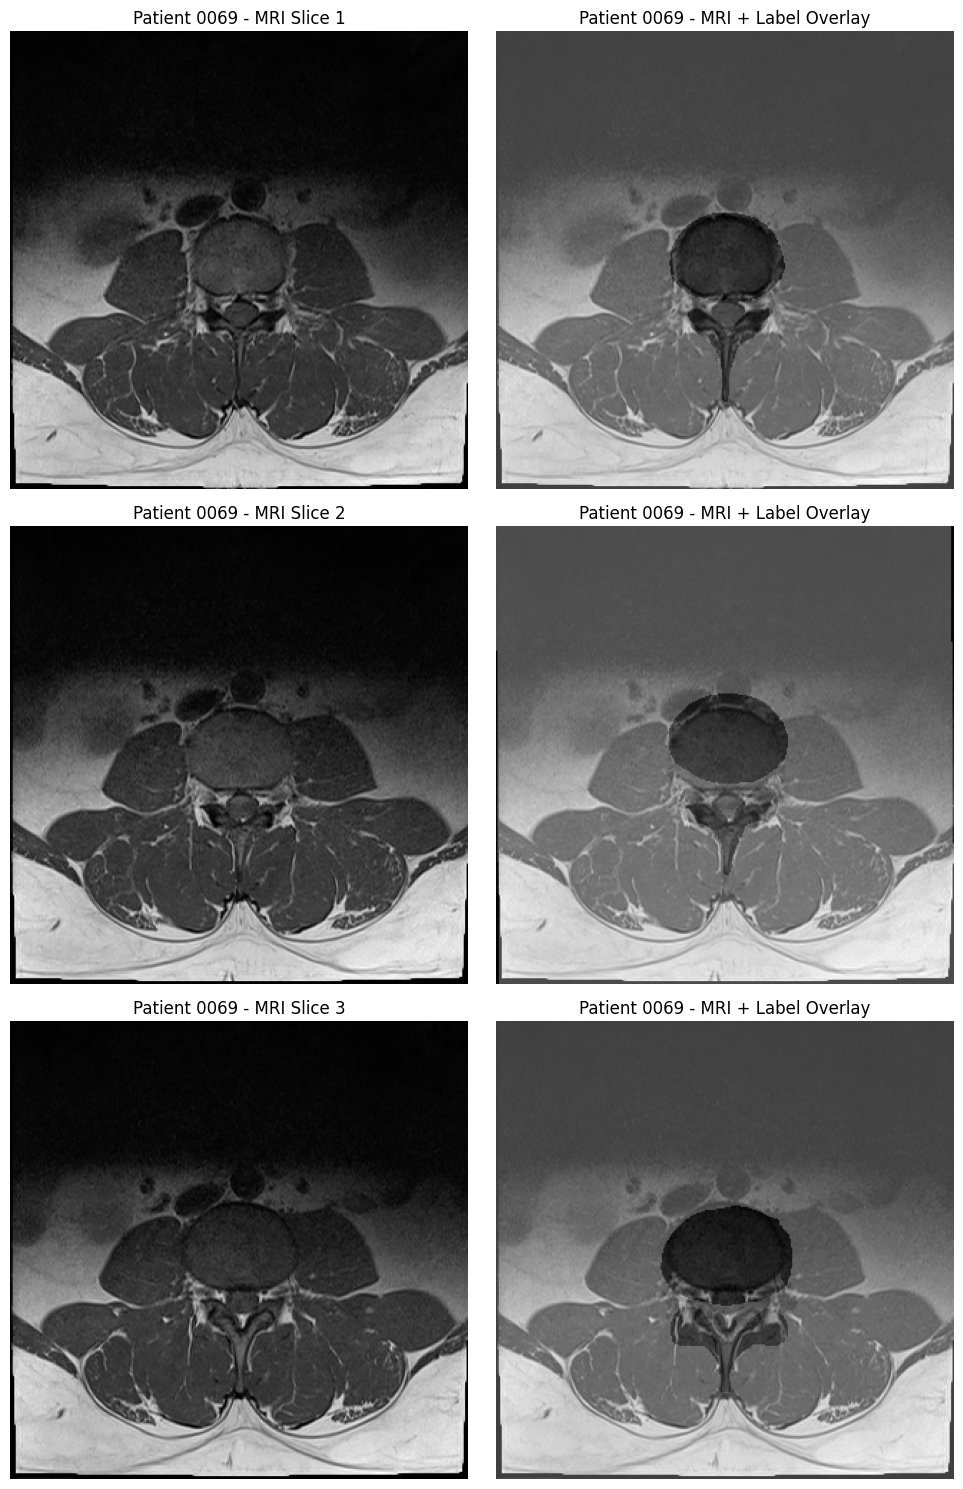

In [ ]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Paths
MRI_PATH = "/content/drive/MyDrive/MRI_data"
LABELS_PATH = "/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images"

# Select a patient manually OR randomly
PATIENT_ID = "0069"  # Change this to any patient ID you want to check

# Locate MRI Axial View Folder (T1_TSE_TRA_0005)
mri_patient_folder = os.path.join(MRI_PATH, PATIENT_ID)
subfolders = [f for f in os.listdir(mri_patient_folder) if os.path.isdir(os.path.join(mri_patient_folder, f))]

axial_view_folder = None
for subfolder in subfolders:
    full_path = os.path.join(mri_patient_folder, subfolder, "T1_TSE_TRA_0005")  # Adjust if necessary
    if os.path.exists(full_path):
        axial_view_folder = full_path
        break

if not axial_view_folder:
    print(f" No axial view folder found for Patient {PATIENT_ID}")
else:
    print(f" Axial View Folder Found: {axial_view_folder}")

# Get all .ima files
mri_files = sorted(glob(os.path.join(axial_view_folder, "*.ima")))
if not mri_files:
    print(" No .ima files found!")
else:
    print(f" Found {len(mri_files)} MRI slices")

# Load Label Images
label_files = sorted(glob(os.path.join(LABELS_PATH, f"L1_{PATIENT_ID}_D*.png")))
if not label_files:
    print(" No label images found!")
else:
    print(f" Found {len(label_files)} Label Images")

# Function to Read and Convert MRI (.ima) to Image
def load_mri_image(ima_path):
    dicom_data = pydicom.dcmread(ima_path)
    image_array = dicom_data.pixel_array
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return image_array

# Function to Overlay Label on MRI
def overlay_label(mri_img, label_img_path):
    label_img = cv2.imread(label_img_path, cv2.IMREAD_GRAYSCALE)
    label_img = cv2.resize(label_img, (mri_img.shape[1], mri_img.shape[0]))  # Resize label to match MRI
    overlay = cv2.addWeighted(mri_img, 0.7, label_img, 0.3, 0)  # Blend images
    return overlay

# Visualization
num_samples = min(3, len(mri_files), len(label_files))  # Show max 3 images
plt.figure(figsize=(10, num_samples * 5))

for i in range(num_samples):
    mri_img = load_mri_image(mri_files[i])
    label_img_path = label_files[i]
    overlay_img = overlay_label(mri_img, label_img_path)

    # Show MRI and Overlay
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.imshow(mri_img, cmap='gray')
    plt.title(f"Patient {PATIENT_ID} - MRI Slice {i+1}")
    plt.axis("off")

    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.imshow(overlay_img, cmap='gray')
    plt.title(f"Patient {PATIENT_ID} - MRI + Label Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Confirming ground truth labels and MRI shape and dimensions

In [ ]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

# Paths
MRI_PATH = "/content/drive/MyDrive/MRI_data"
LABELS_PATH = "/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images"

# Select a patient manually OR randomly
PATIENT_ID = "0050"  # Change this to any patient ID you want to check

# Locate MRI Axial View Folder (T1_TSE_TRA_0005)
mri_patient_folder = os.path.join(MRI_PATH, PATIENT_ID)
subfolders = [f for f in os.listdir(mri_patient_folder) if os.path.isdir(os.path.join(mri_patient_folder, f))]

axial_view_folder = None
for subfolder in subfolders:
    full_path = os.path.join(mri_patient_folder, subfolder, "T1_TSE_TRA_0005")  # Adjust if necessary
    if os.path.exists(full_path):
        axial_view_folder = full_path
        break

if not axial_view_folder:
    print(f" No axial view folder found for Patient {PATIENT_ID}")
else:
    print(f" Axial View Folder Found: {axial_view_folder}")

# Get all .ima files
mri_files = sorted(glob(os.path.join(axial_view_folder, "*.ima")))
if not mri_files:
    print(" No .ima files found!")
else:
    print(f" Found {len(mri_files)} MRI slices")

# Load Label Images
label_files = sorted(glob(os.path.join(LABELS_PATH, f"L1_{PATIENT_ID}_D*.png")))
if not label_files:
    print(" No label images found!")
else:
    print(f" Found {len(label_files)} Label Images")

# Print dimensions(shape) of first 3  for debugging
for i in range(3):
    mri_img = load_mri_image(mri_files[i])
    label_img_path = label_files[i]
    print(f"MRI Shape: {mri_img.shape}, Label Shape: {cv2.imread(label_img_path, cv2.IMREAD_GRAYSCALE).shape}")



 Axial View Folder Found: /content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005
 Found 15 MRI slices
 Found 3 Label Images
MRI Shape: (320, 320), Label Shape: (320, 320)
MRI Shape: (320, 320), Label Shape: (320, 320)
MRI Shape: (320, 320), Label Shape: (320, 320)


# Storing the T1 Weighted Axial view slices in .npy, and there corresponding Label Images
1. The processed files with matching names are stored in Processed_Data file in drive.
2. The label images are mapped from grayscale to class ID's for better visualization of lables which contains background + classes
3. Data preprocessing
4. Resizing images

In [ ]:

from tqdm import tqdm  # Progress bar


# Paths
MRI_PATH = "/content/drive/MyDrive/MRI_data"
LABELS_PATH = "/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images"
OUTPUT_PATH = "/content/drive/MyDrive/Processed_Data"  # Directory to save preprocessed data

# Create output directories
os.makedirs(os.path.join(OUTPUT_PATH, "mri_slices"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "labels"), exist_ok=True)

# Define mapping from grayscale values to class IDs
GRAYSCALE_TO_CLASS = {
    50: 1,  # IVD
    100: 2,  # PE
    150: 3,  # TS
    200: 4,  # AAP
    250: 0   # Background
}

# Function to load and preprocess MRI slices
def load_mri_image(ima_path):
    dicom_data = pydicom.dcmread(ima_path)
    image_array = dicom_data.pixel_array
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return image_array

# Function to convert grayscale label to multi-class mask
def convert_to_multiclass(label_img):
    multiclass_mask = np.zeros_like(label_img, dtype=np.uint8)  # Initialize with background (0)
    for gray_value, class_id in GRAYSCALE_TO_CLASS.items():
        multiclass_mask[label_img == gray_value] = class_id
    return multiclass_mask

# Function to preprocess label images
def preprocess_label(label_path, target_size):
    label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    label_img = cv2.resize(label_img, target_size, interpolation=cv2.INTER_NEAREST)  # Resize label
    label_img = convert_to_multiclass(label_img)  # Convert to multi-class mask
    return label_img

# Target size for resizing
TARGET_SIZE = (256, 256)

# Iterate through all patient folders
for PATIENT_ID in tqdm(sorted(os.listdir(MRI_PATH)), desc="Processing Patients"):
    mri_patient_folder = os.path.join(MRI_PATH, PATIENT_ID)
    if not os.path.isdir(mri_patient_folder):
        continue  # Skip non-directory files

    # Locate the T1-weighted axial-view folder
    axial_view_folder = None
    for subfolder in os.listdir(mri_patient_folder):
        full_path = os.path.join(mri_patient_folder, subfolder, "T1_TSE_TRA_0005")
        if os.path.exists(full_path):
            axial_view_folder = full_path
            break

    if not axial_view_folder:
        print(f" No axial view folder found for Patient {PATIENT_ID}")
        continue  # Skip this patient

    # Get all .ima files in the axial view folder
    mri_files = sorted(glob(os.path.join(axial_view_folder, "*.ima")))
    if not mri_files:
        print(f" No .ima files found for Patient {PATIENT_ID}")
        continue

    # Get corresponding label files
    label_files = sorted(glob(os.path.join(LABELS_PATH, f"L1_{PATIENT_ID}_D*.png")))
    if not label_files:
        print(f" No label images found for Patient {PATIENT_ID}")
        continue

    # Process each MRI slice and corresponding label
    for mri_file, label_file in zip(mri_files, label_files):
        try:
            # Load and preprocess MRI slice
            mri_img = load_mri_image(mri_file)
            mri_img = cv2.resize(mri_img, TARGET_SIZE)  # Resize MRI slice
            mri_img = mri_img.astype(np.float32) / 255.0  # Normalize to [0, 1]

            # Load and preprocess label
            label_img = preprocess_label(label_file, TARGET_SIZE)

            # Generate consistent filenames
            slice_number = os.path.basename(mri_file).split("_")[-1].split(".")[0]  # Extract slice number
            mri_output_filename = f"{PATIENT_ID}_slice_{slice_number}.npy"
            label_output_filename = f"{PATIENT_ID}_slice_{slice_number}_label.npy"

            # Save preprocessed MRI slice and label
            mri_output_path = os.path.join(OUTPUT_PATH, "mri_slices", mri_output_filename)
            label_output_path = os.path.join(OUTPUT_PATH, "labels", label_output_filename)

            np.save(mri_output_path, mri_img)
            np.save(label_output_path, label_img)

            print(f" Saved: {mri_output_path}, {label_output_path}")
        except Exception as e:
            print(f" Error processing {mri_file} or {label_file}: {e}")
            continue

print(" Preprocessing complete! Data saved to:", OUTPUT_PATH)

In [ ]:
print("MRI Files:", mri_files[:5])  # Print first 5 MRI filenames
print("Label Files:", label_files[:5])  # Print first 5 label filenames

MRI Files: ['/content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005/T1_TSE_TRA__0050_001.ima', '/content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005/T1_TSE_TRA__0050_002.ima', '/content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005/T1_TSE_TRA__0050_003.ima', '/content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005/T1_TSE_TRA__0050_004.ima', '/content/drive/MyDrive/MRI_data/0050/L-SPINE_CLINICAL_LIBRARIES_20160623_123514_389000/T1_TSE_TRA_0005/T1_TSE_TRA__0050_005.ima']
Label Files: ['/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images/L1_0050_D3.png', '/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images/L1_0050_D4.png', '/content/drive/MyDrive/Final_Ground_Truth_Data/Label_Images/L1_0050_D5.png']


# Overlaying
The label image stored in Processed_Data previously, is overlayed on the MRI slice from the same folder.

Unique Values in Processed Label: [0 1 2 3 4]


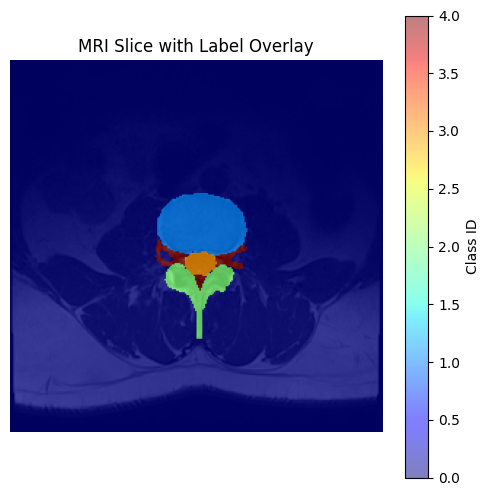

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the processed label
label_file_path = "/content/drive/MyDrive/Processed_Data/labels/0002_slice_001_label.npy"
processed_label = np.load(label_file_path)

# Load the corresponding MRI slice
mri_file_path = "/content/drive/MyDrive/Processed_Data/mri_slices/0002_slice_001.npy"
processed_mri = np.load(mri_file_path)

# Print unique values in the processed label
unique_values = np.unique(processed_label)
print("Unique Values in Processed Label:", unique_values)

# Plot MRI slice with overlay of the processed label
plt.figure(figsize=(6, 6))

# Display the MRI slice
plt.imshow(processed_mri, cmap="gray")  # Use 'gray' colormap for MRI
plt.title("MRI Slice with Label Overlay")

# Overlay the processed label with transparency
plt.imshow(processed_label, cmap="jet", alpha=0.5, vmin=0, vmax=4)  # Use 'jet' colormap for multi-class
plt.axis("off")

# Add colorbar for the label
cbar = plt.colorbar(plt.imshow(processed_label, cmap="jet", alpha=0.5, vmin=0, vmax=4))
cbar.set_label("Class ID")

plt.show()


Sample 1:
 - MRI shape: (256, 256, 1)
 - Label shape: (256, 256, 1)


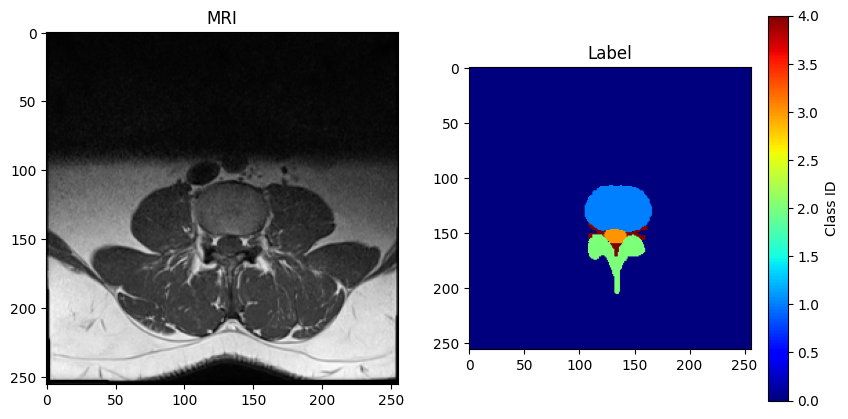

Sample 2:
 - MRI shape: (256, 256, 1)
 - Label shape: (256, 256, 1)


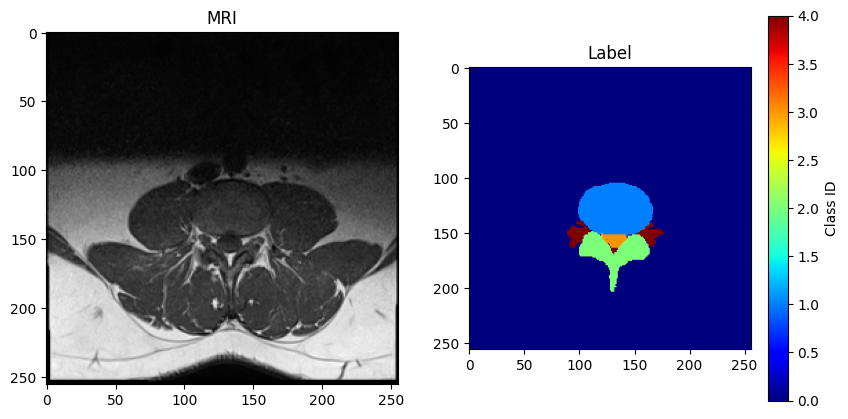

Sample 3:
 - MRI shape: (256, 256, 1)
 - Label shape: (256, 256, 1)


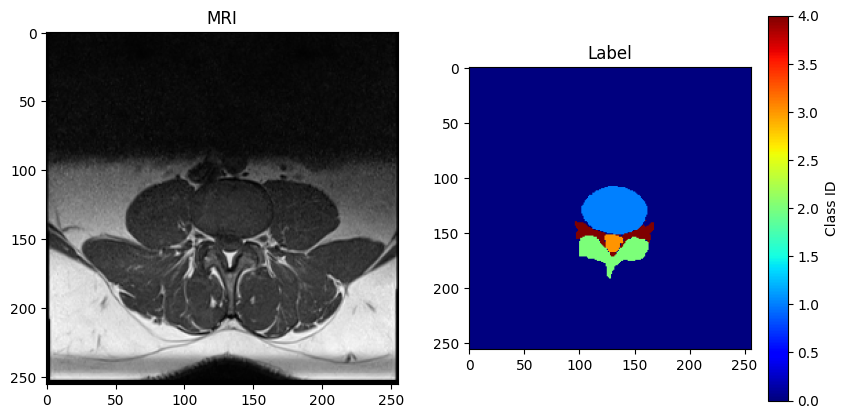

Sample 4:
 - MRI shape: (256, 256, 1)
 - Label shape: (256, 256, 1)


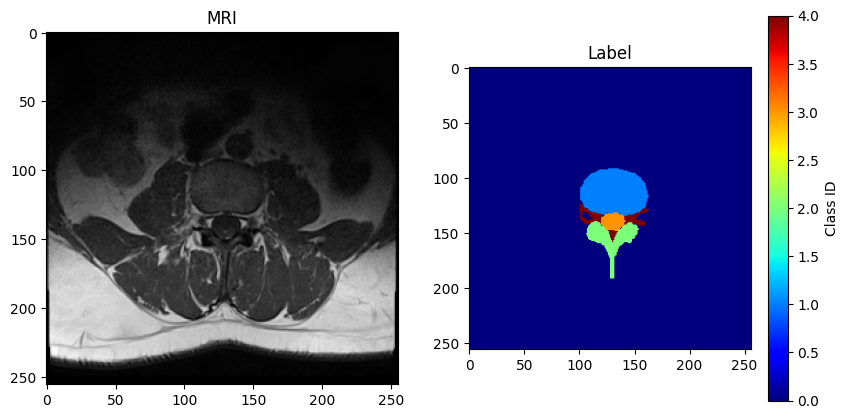

Sample 5:
 - MRI shape: (256, 256, 1)
 - Label shape: (256, 256, 1)


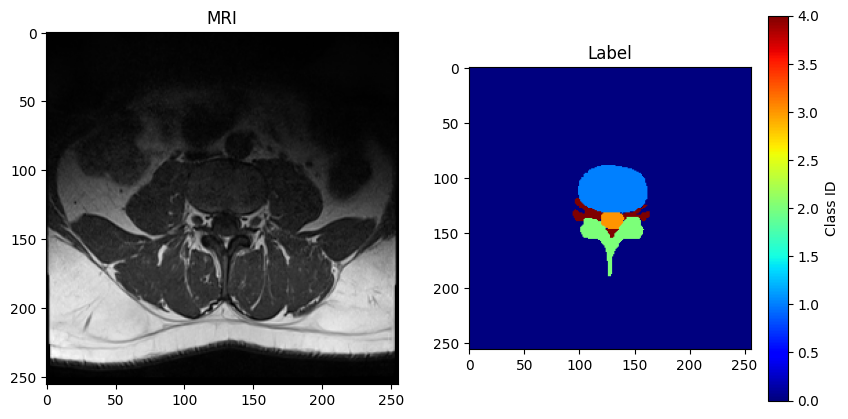

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

# Paths (assuming these are defined in the preceding code)
OUTPUT_PATH = "/content/drive/MyDrive/Processed_Data"
PROCESSED_MRI_PATH = os.path.join(OUTPUT_PATH, "mri_slices")
PROCESSED_LABELS_PATH = os.path.join(OUTPUT_PATH, "labels")

# Get list of preprocessed MRI and label files
mri_files = sorted([os.path.join(PROCESSED_MRI_PATH, f) for f in os.listdir(PROCESSED_MRI_PATH) if f.endswith(".npy")])
label_files = sorted([os.path.join(PROCESSED_LABELS_PATH, f) for f in os.listdir(PROCESSED_LABELS_PATH) if f.endswith(".npy")])


# Function to load data (same as before)
def load_data(mri_path, label_path):
    mri_slice = np.load(mri_path).astype(np.float32)
    label = np.load(label_path).astype(np.float32)
    mri_slice = np.expand_dims(mri_slice, axis=-1)
    label = np.expand_dims(label, axis=-1)
    return mri_slice, label


# Check shapes and print images for a few samples
num_samples_to_check = min(5, len(mri_files)) # Check up to 5 samples

for i in range(num_samples_to_check):
    mri_path = mri_files[i]
    label_path = label_files[i]

    mri, label = load_data(mri_path, label_path)
    print(f"Sample {i+1}:")
    print(f" - MRI shape: {mri.shape}")
    print(f" - Label shape: {label.shape}")

    # Display MRI and Label
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(mri), cmap='gray')
    plt.title("MRI")

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(label), cmap='jet') # Use jet for better visualization
    plt.title("Label")
    plt.colorbar(label="Class ID")

    plt.show()


In [ ]:
# ================== CONFIGURATION ================== #
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 20
NUM_CLASSES = 5
CLASS_NAMES = ['Background', 'IVD', 'PE', 'TS', 'AAP']
AUTOTUNE = tf.data.AUTOTUNE

# Making a tensorflow dataset
 1. Checking the names of files in label and MRI slice folder
 2. Training 70%, validation 15%, testing = dataset_size - train_size - val_size

In [ ]:
import tensorflow as tf
import numpy as np
import os

# Paths
OUTPUT_PATH = "/content/drive/MyDrive/Processed_Data"
PROCESSED_MRI_PATH = os.path.join(OUTPUT_PATH, "mri_slices")
PROCESSED_LABELS_PATH = os.path.join(OUTPUT_PATH, "labels")

# Get list of preprocessed MRI and label files
mri_files = sorted([os.path.join(PROCESSED_MRI_PATH, f) for f in os.listdir(PROCESSED_MRI_PATH) if f.endswith(".npy")])
label_files = sorted([os.path.join(PROCESSED_LABELS_PATH, f) for f in os.listdir(PROCESSED_LABELS_PATH) if f.endswith(".npy")])

# Print first few filenames for debugging
print("MRI Files:", mri_files[:5])
print("Label Files:", label_files[:5])

# Verify that MRI and label files match
assert len(mri_files) == len(label_files), "Mismatch between MRI and label files"

# Check filename consistency
for mri_file, label_file in zip(mri_files, label_files):
    mri_filename = os.path.basename(mri_file)
    label_filename = os.path.basename(label_file)

    # Ensure the filenames match (e.g., "0001_slice_001.npy" and "0001_slice_001_label.npy")
    if not label_filename == mri_filename.replace(".npy", "_label.npy"):
        print(f"Filename mismatch: {mri_filename} vs {label_filename}")
        raise AssertionError("Filename mismatch")

print(" All MRI and label filenames match!")

# Function to load and preprocess data

def load_data(mri_path, label_path):
    mri_slice = np.load(mri_path).astype(np.float32)  # Ensure float32 for MRI
    label = np.load(label_path).astype(np.float32)    # Ensure float32 for labels

    # Add channel dimension
    mri_slice = np.expand_dims(mri_slice, axis=-1)  # Shape: (256, 256, 1)
    label = np.expand_dims(label, axis=-1)          # Shape: (256, 256, 1)

    return mri_slice, label

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((mri_files, label_files))

# Map the dataset using the load_data function
dataset = dataset.map(lambda mri_path, label_path: tf.numpy_function(
    load_data, [mri_path, label_path], [tf.float32, tf.float32]  # Ensure both are float32
))



# Explicitly set the shapes of the tensors
def set_shapes(mri, label):
    mri.set_shape((256, 256, 1))   # MRI shape is (256, 256, 1)
    label.set_shape((256, 256, 1))  # Label shape is now (256, 256, 1)
    return mri, label

dataset = dataset.map(set_shapes)


def one_hot_encode(mri, label):
    label = tf.one_hot(tf.cast(label[..., 0], tf.int32), depth=NUM_CLASSES)  # One-hot encode
    return mri, label

dataset = dataset.map(one_hot_encode)
# Split the dataset into training, validation, and test sets
dataset_size = len(mri_files)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Shuffle and split the dataset
dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

# Batch and prefetch the datasets

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print(f"Training set: {train_size} samples")
print(f"Validation set: {val_size} samples")
print(f"Test set: {test_size} samples")

MRI Files: ['/content/drive/MyDrive/Processed_Data/mri_slices/0001_slice_001.npy', '/content/drive/MyDrive/Processed_Data/mri_slices/0001_slice_002.npy', '/content/drive/MyDrive/Processed_Data/mri_slices/0001_slice_003.npy', '/content/drive/MyDrive/Processed_Data/mri_slices/0002_slice_001.npy', '/content/drive/MyDrive/Processed_Data/mri_slices/0002_slice_002.npy']
Label Files: ['/content/drive/MyDrive/Processed_Data/labels/0001_slice_001_label.npy', '/content/drive/MyDrive/Processed_Data/labels/0001_slice_002_label.npy', '/content/drive/MyDrive/Processed_Data/labels/0001_slice_003_label.npy', '/content/drive/MyDrive/Processed_Data/labels/0002_slice_001_label.npy', '/content/drive/MyDrive/Processed_Data/labels/0002_slice_002_label.npy']
 All MRI and label filenames match!
Training set: 153 samples
Validation set: 32 samples
Test set: 34 samples


# Segmentation Model

In [ ]:
# ================= MODEL ARCHITECTURES ================ #
def create_unet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    # Bottleneck
    b = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    b = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(b)

    # Decoder
    u1 = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(u1)
    c3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    u2 = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(c3)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(u2)
    c4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, activation='softmax')(c4)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

def create_resnet_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights=None,
        input_shape=input_shape
    )
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(np.prod(IMG_SIZE) * num_classes, activation='softmax')(x)
    x = tf.keras.layers.Reshape((*IMG_SIZE, num_classes))(x)
    return tf.keras.Model(inputs=base_model.input, outputs=x)


In [ ]:
# ================== METRICS & UTILS ================== #
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_start_time = datetime.datetime.now()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append((datetime.datetime.now() - self.epoch_start_time).total_seconds())

def calculate_metrics(y_true, y_pred):
    y_true_flat = np.argmax(y_true, axis=-1).flatten()
    y_pred_flat = np.argmax(y_pred, axis=-1).flatten()

    precision = precision_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='weighted', zero_division=0)
    return precision, recall


In [ ]:
# ================== DATA PIPELINE ================== #
def augment_data(image, label):
    # Random flips
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    label = tf.image.rot90(label, k)

    # Random brightness
    image = tf.image.random_brightness(image, 0.1)
    return image, label

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(dataset, num_classes):
    labels = []
    for _, y in dataset:
        labels.extend(np.argmax(y.numpy(), axis=-1).flatten())  # Convert one-hot to class indices

    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.arange(num_classes),
                                         y=labels)

    return dict(enumerate(class_weights))

# Compute weights
class_weights = get_class_weights(train_dataset, NUM_CLASSES)
print("Class Weights:", class_weights)


Class Weights: {0: 0.21310647334571903, 1: 5.565056777187004, 2: 12.344199388145785, 3: 62.85540197461213, 4: 32.36450139599438}


In [ ]:
# ================== MODEL TRAINING ================== #
def train_and_evaluate(model, model_name, train_ds, val_ds, test_ds):
    time_callback = TimeHistory()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)])

    start_time = datetime.datetime.now()
    history = model.fit(train_ds,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        class_weight=class_weights,
                        callbacks=[early_stopping, time_callback])
    total_time = datetime.datetime.now() - start_time

    # Evaluation
    test_results = model.evaluate(test_ds, verbose=0)
    y_pred = model.predict(test_ds, verbose=0)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    # Calculate additional metrics
    precision, recall = calculate_metrics(y_true, y_pred)

    return {
        'model': model,
        'history': history,
        'test_results': test_results,
        'y_true': y_true,
        'y_pred': y_pred,
        'time_info': {
            'total': total_time.total_seconds(),
            'per_epoch': time_callback.times
        },
        'precision': precision,
        'recall': recall
    }

In [ ]:
# ================== MAIN EXECUTION ================== #
if __name__ == "__main__":
    # Load and prepare dataset
    # [Include your dataset loading code here]
    # ... [Your existing dataset code] ...

    # Initialize models
    models = {
        "U-Net": create_unet_model((*IMG_SIZE, 1), NUM_CLASSES),
        "ResNet": create_resnet_model((*IMG_SIZE, 1), NUM_CLASSES),
        #"CNN": create_cnn_model((*IMG_SIZE, 1), NUM_CLASSES),
        #"ANN": create_ann_model((*IMG_SIZE, 1), NUM_CLASSES),
        #"LeNet": create_lenet_model((*IMG_SIZE, 1), NUM_CLASSES)
    }

    results = {}

    # Train and evaluate all models
    for model_name, model in models.items():
        print(f"\n{'='*40}\nTraining {model_name}\n{'='*40}")
        results[model_name] = train_and_evaluate(model, model_name, train_dataset, val_dataset, test_dataset)



Training U-Net
Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3242 - loss: 1.6138 - mean_io_u: 0.4000 - val_accuracy: 0.3407 - val_loss: 1.6364 - val_mean_io_u: 0.4000
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.3440 - loss: 1.5891 - mean_io_u: 0.4000 - val_accuracy: 0.5129 - val_loss: 1.7424 - val_mean_io_u: 0.4000
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 356ms/step - accuracy: 0.6428 - loss: 1.4692 - mean_io_u: 0.4000 - val_accuracy: 0.8093 - val_loss: 1.4730 - val_mean_io_u: 0.4000
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.8421 - loss: 1.3758 - mean_io_u: 0.4000 - val_accuracy: 0.7009 - val_loss: 1.4222 - val_mean_io_u: 0.4000
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.7749 - loss: 1.2728 - mean_io_u: 0.4000 - val_accuracy: 0.7502 - val_loss: 0.8637 - val_mean_io_u: 0.4000
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 401ms/step - accuracy: 0.7587 - loss: 1.0857 - mean_io_u: 0.4000 - val_accuracy: 0

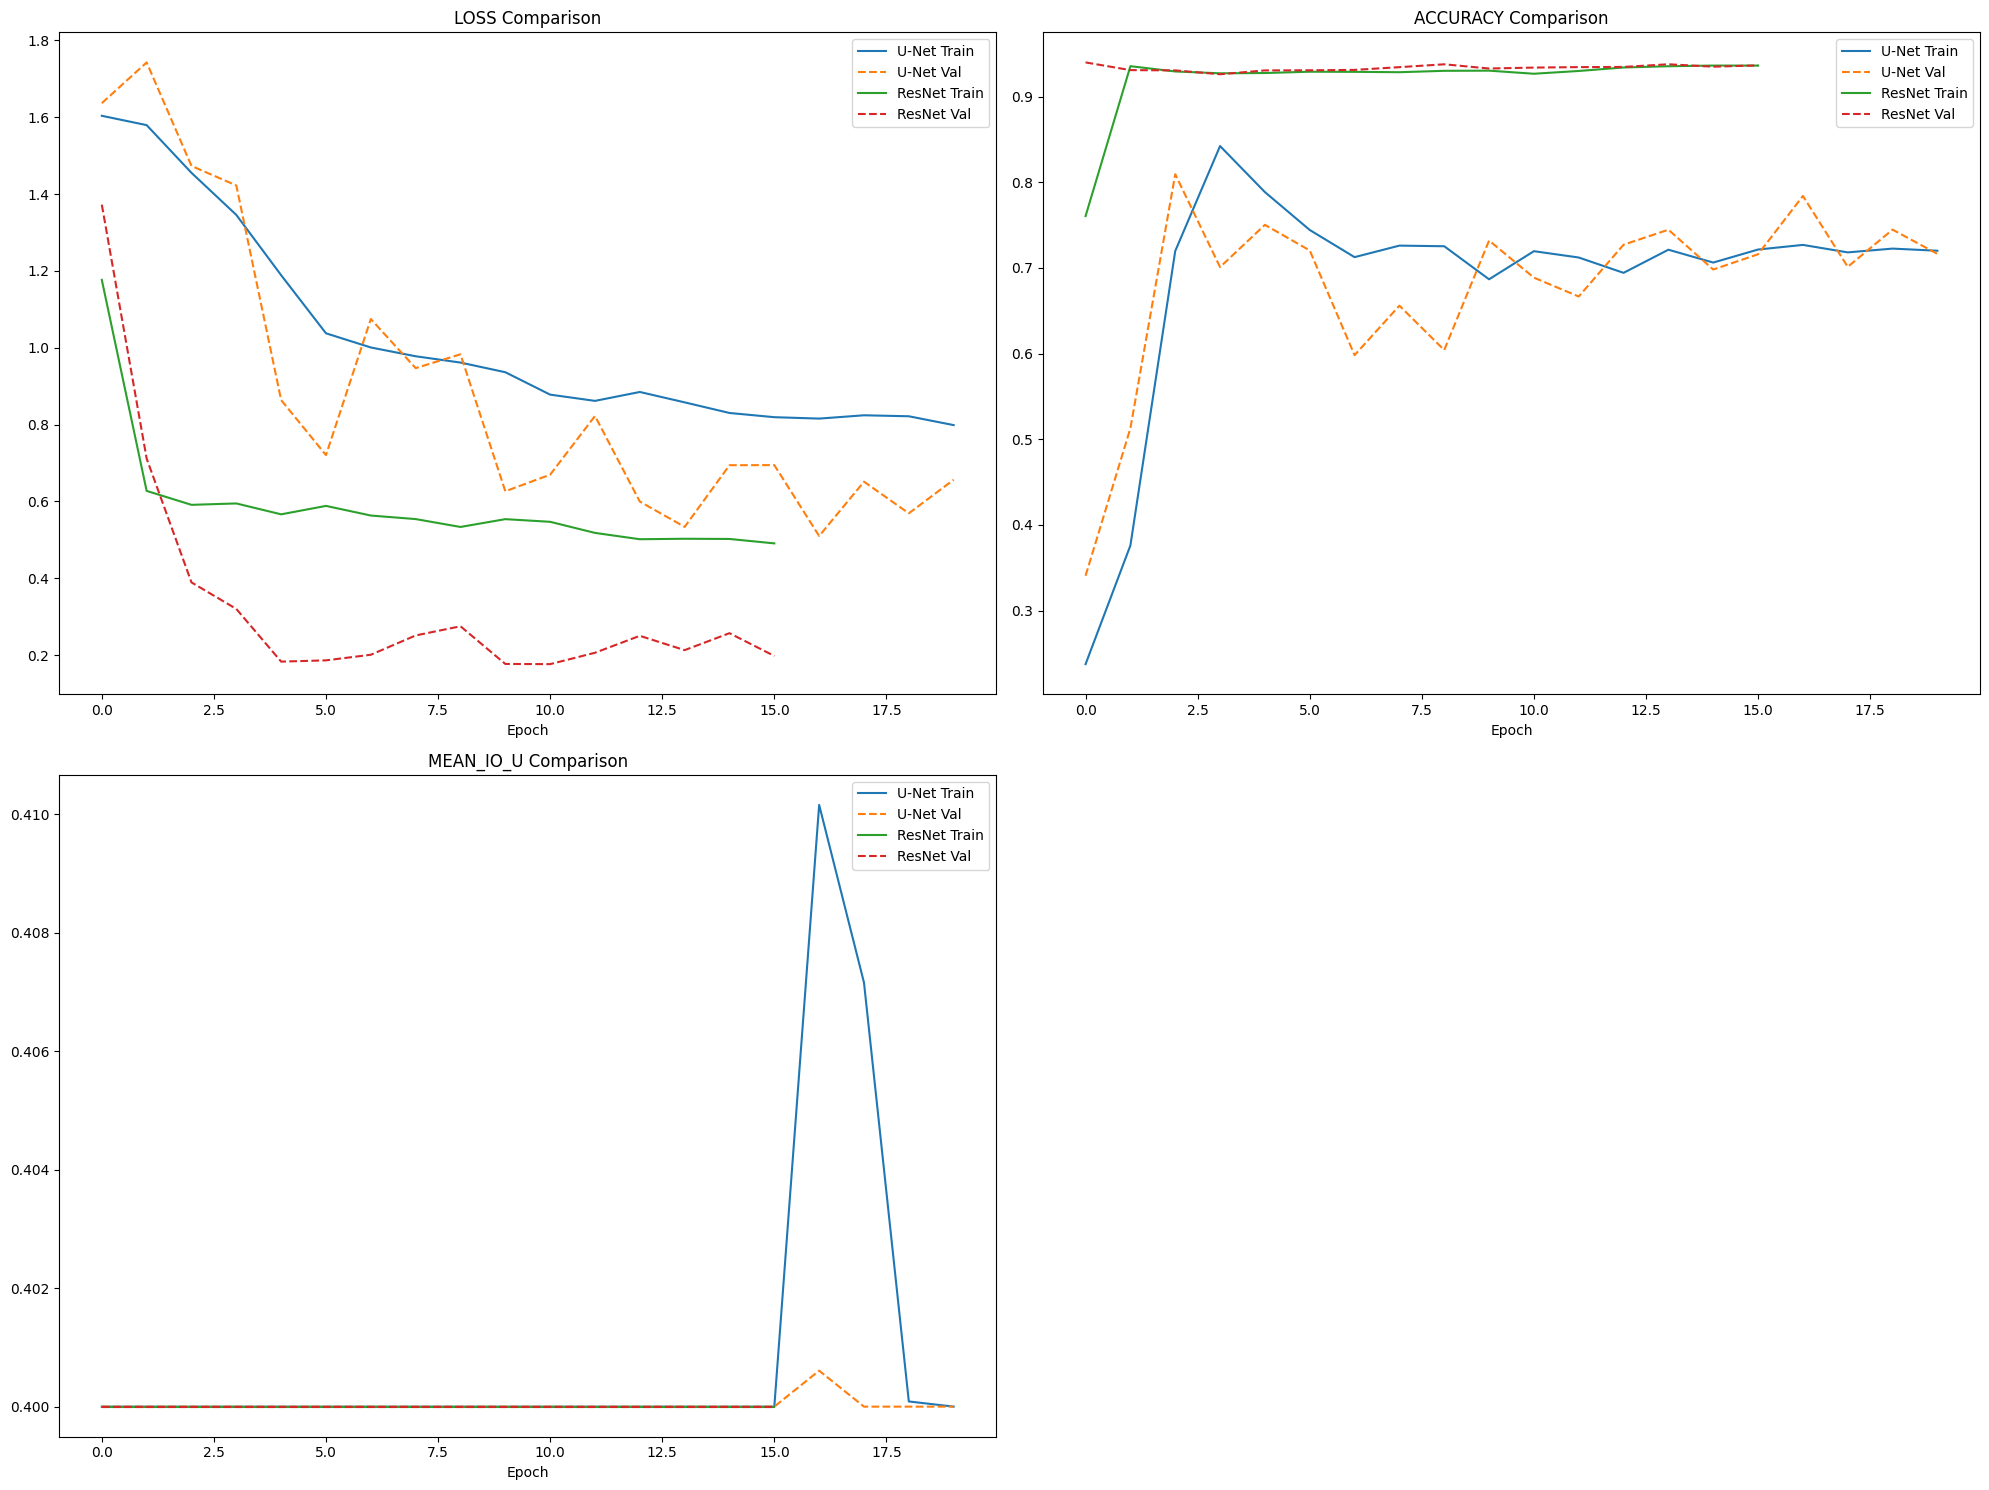

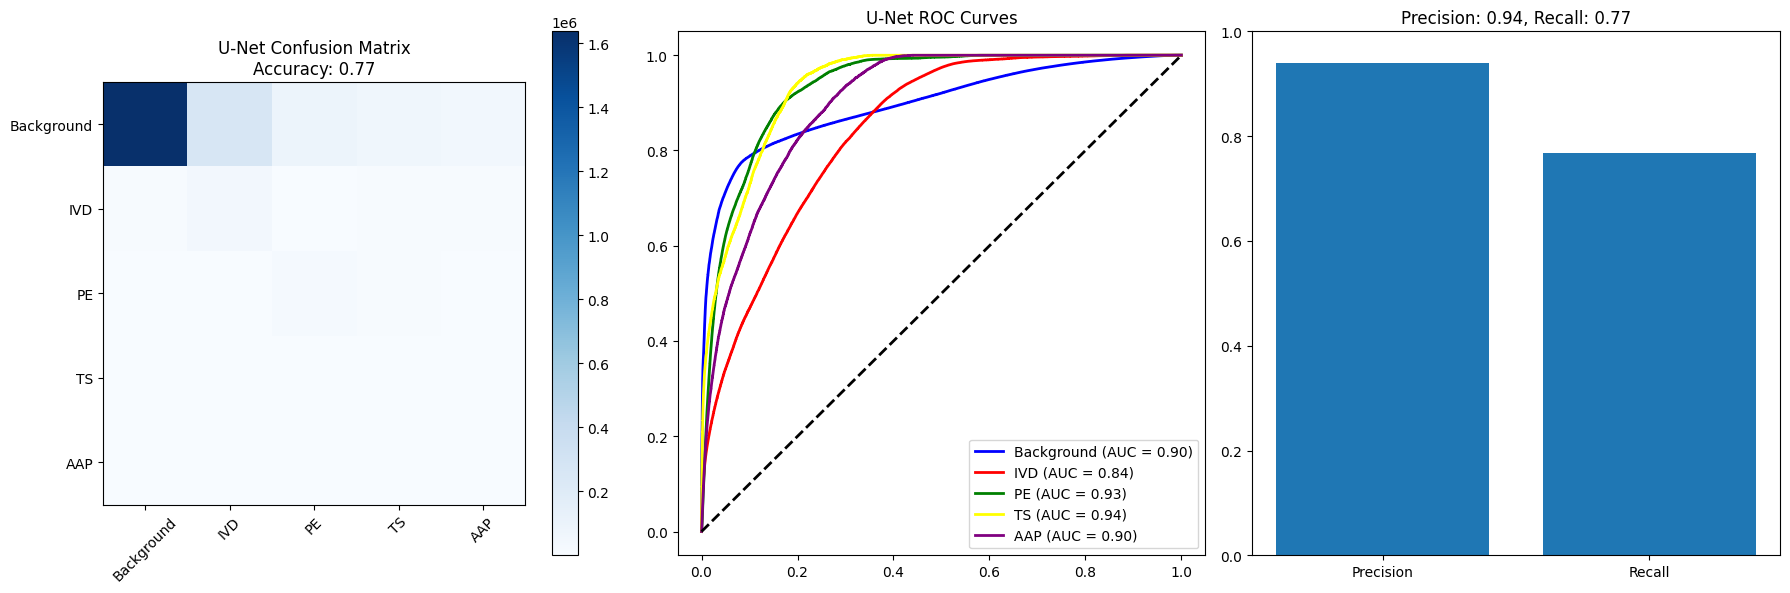

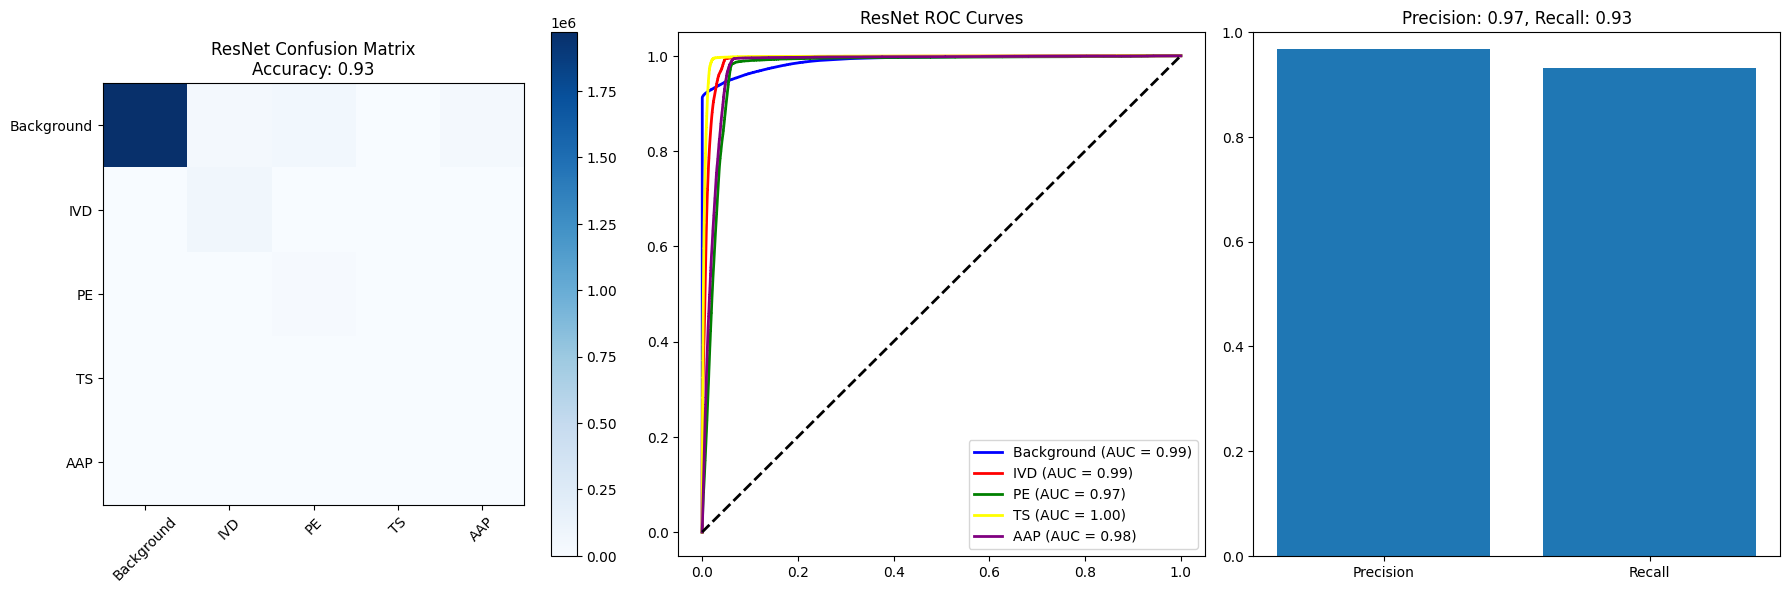

In [ ]:
# ================== VISUALIZATION ================== #
# Plot training metrics
def plot_training_curves(results):
    metrics = ['loss', 'accuracy', 'mean_io_u']  # List of metrics to plot
    plt.figure(figsize=(20, 15))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i + 1)
        for model_name, result in results.items():
            # Access metric from history using its actual name (e.g., 'mean_io_u_1')
            metric_name = [key for key in result['history'].history if metric in key][0]
            plt.plot(result['history'].history[metric_name], label=f'{model_name} Train')

            # Access validation metric from history
            val_metric_name = [key for key in result['history'].history if f'val_{metric}' in key][0]
            plt.plot(result['history'].history[val_metric_name], '--', label=f'{model_name} Val')
        plt.title(f'{metric.upper()} Comparison')
        plt.xlabel('Epoch')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_curves(results)

    # Confusion Matrix and ROC
def plot_model_metrics(results):
        for model_name, result in results.items():
            y_true = result['y_true']
            y_pred = result['y_pred']

            # Confusion Matrix
            y_true_flat = np.argmax(y_true, axis=-1).flatten()
            y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
            cm = confusion_matrix(y_true_flat, y_pred_flat)

            plt.figure(figsize=(18, 6))

            # Confusion Matrix
            plt.subplot(1, 3, 1)
            plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f'{model_name} Confusion Matrix\nAccuracy: {result["test_results"][1]:.2f}')
            plt.colorbar()
            plt.xticks(np.arange(NUM_CLASSES), CLASS_NAMES, rotation=45)
            plt.yticks(np.arange(NUM_CLASSES), CLASS_NAMES)

            # ROC Curve
            plt.subplot(1, 3, 2)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            y_true_bin = label_binarize(y_true_flat, classes=np.arange(NUM_CLASSES))

            for i in range(NUM_CLASSES):
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[..., i].flatten())
                roc_auc[i] = auc(fpr[i], tpr[i])

            colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
            for i, color in zip(range(NUM_CLASSES), colors):
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                         label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.2f})')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.title(f'{model_name} ROC Curves')
            plt.legend(loc="lower right")

            # Precision-Recall
            plt.subplot(1, 3, 3)
            plt.bar(['Precision', 'Recall'], [result['precision'], result['recall']])
            plt.ylim(0, 1)
            plt.title(f'Precision: {result["precision"]:.2f}, Recall: {result["recall"]:.2f}')

            plt.tight_layout()
            plt.show()

plot_model_metrics(results)

In [ ]:
# ================== PERFORMANCE TABLE ================== #
print("\n\n=== FINAL PERFORMANCE COMPARISON ===")
print(f"{'Model':<10} {'Accuracy':<10} {'IoU':<10} {'Precision':<10} {'Recall':<10} {'Time (s)':<10}")
for model_name, result in results.items():
    print(f"{model_name:<10} {result['test_results'][1]:<10.4f} {result['test_results'][2]:<10.4f} "
          f"{result['precision']:<10.4f} {result['recall']:<10.4f} {result['time_info']['total']:<10.2f}") # Indented this line



=== FINAL PERFORMANCE COMPARISON ===
Model      Accuracy   IoU        Precision  Recall     Time (s)  
U-Net      0.7679     0.4014     0.9405     0.7677     267.15    
ResNet     0.9285     0.4000     0.9677     0.9304     232.28    



=== U-Net PREDICTION EXAMPLES ===


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step


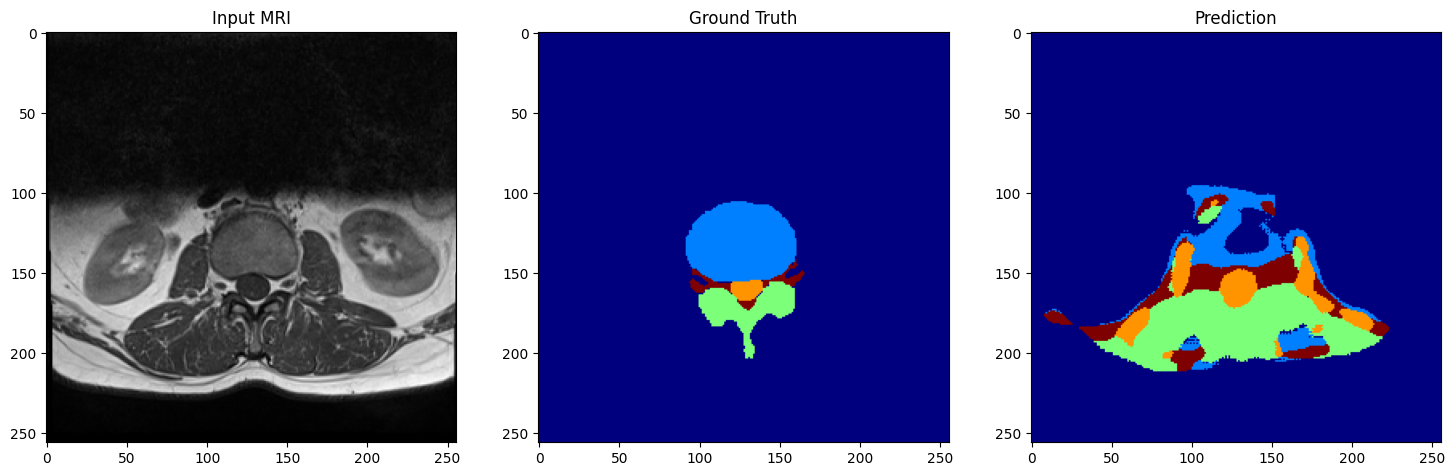

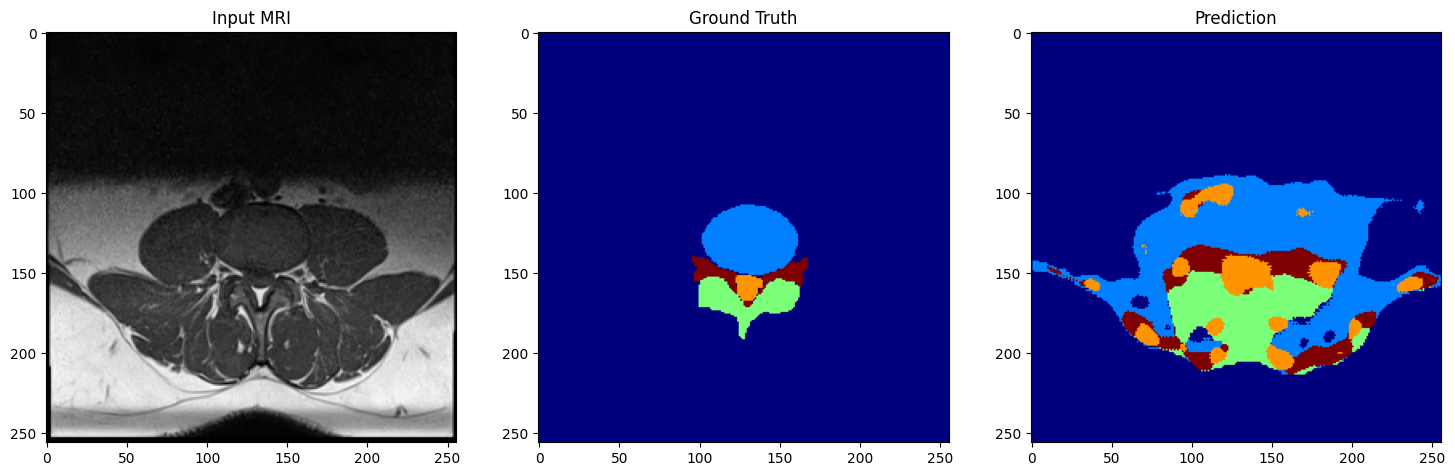

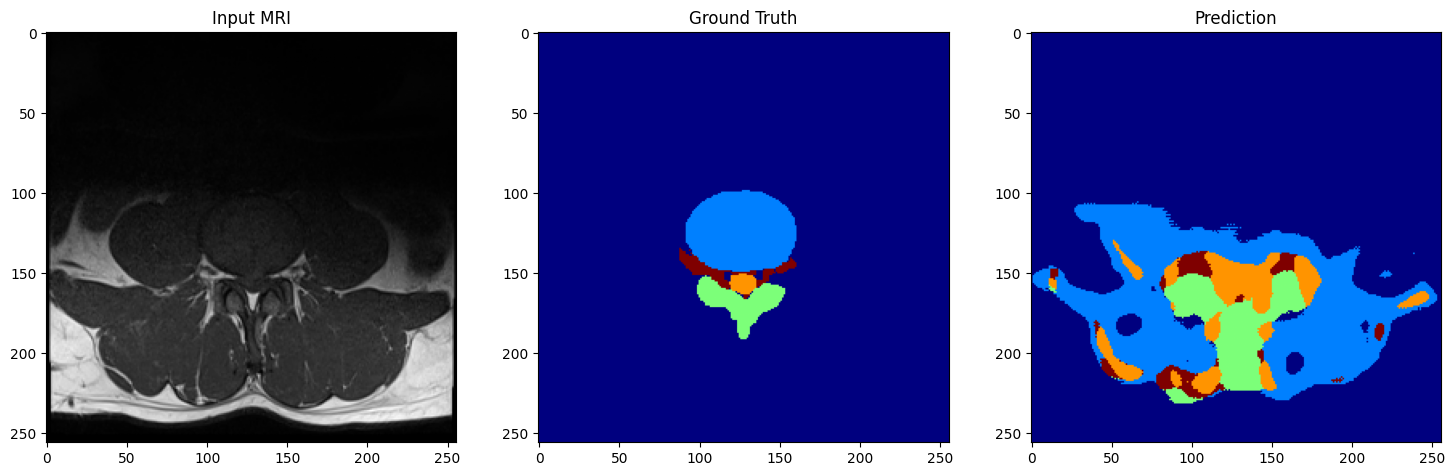


=== ResNet PREDICTION EXAMPLES ===


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


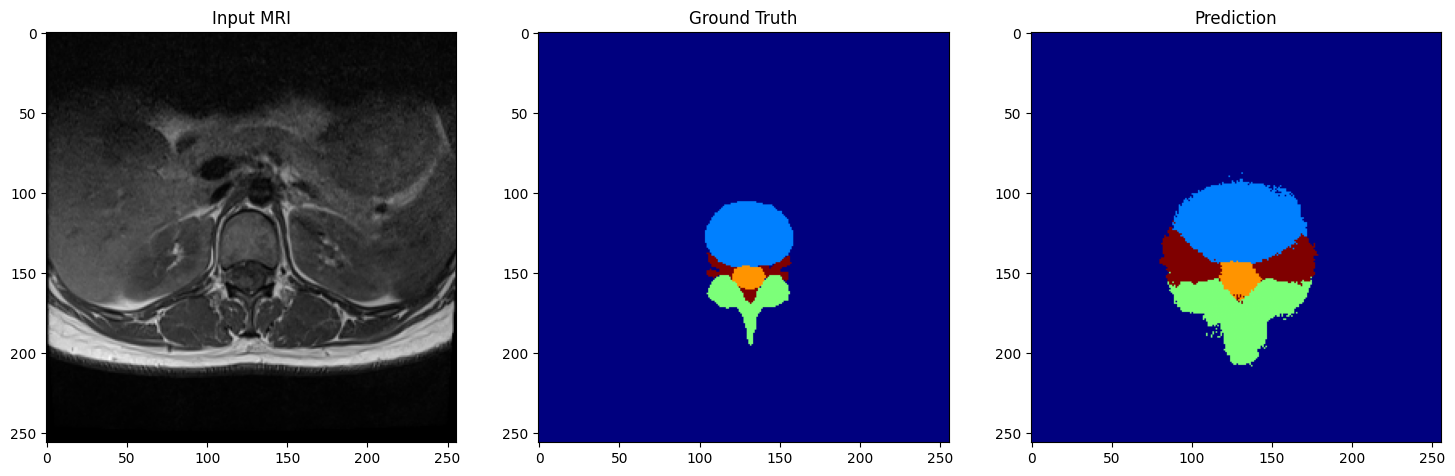

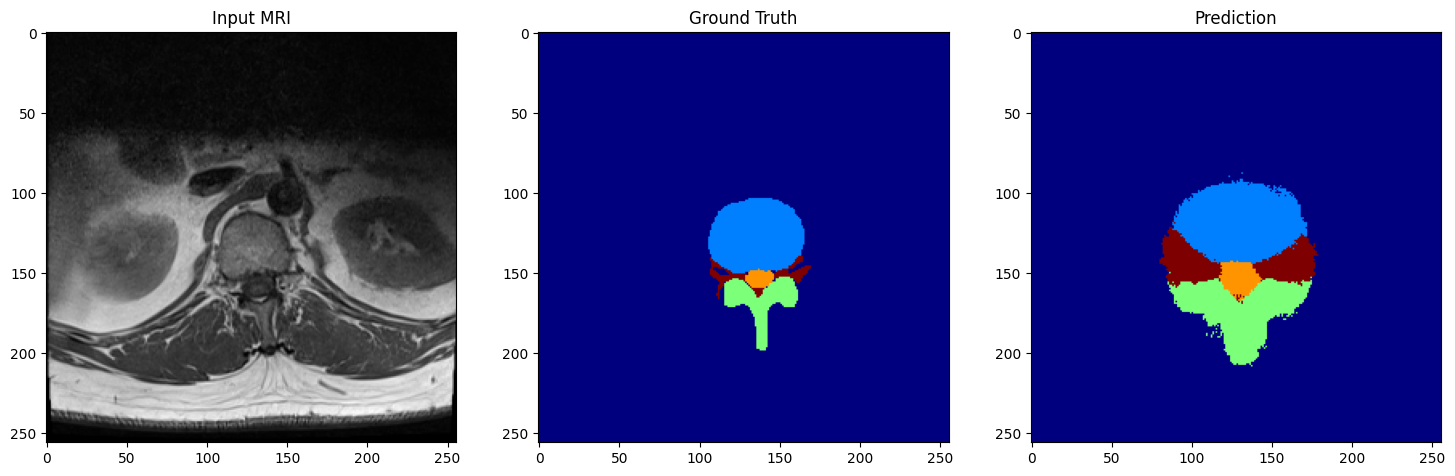

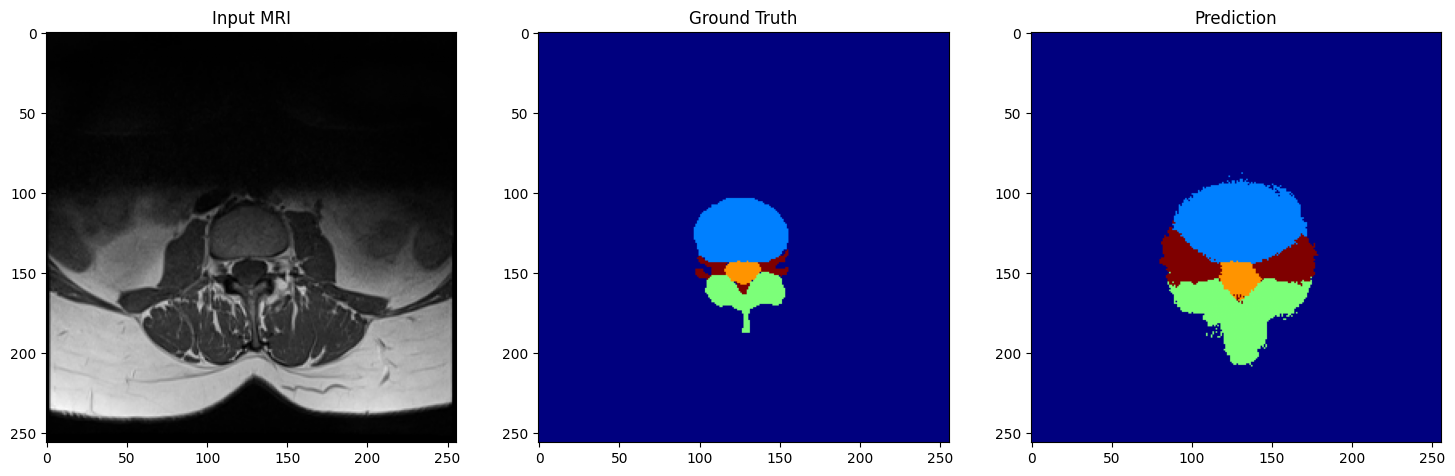

In [ ]:
# ================== SEGMENTATION PREDICTIONS ================== #
def plot_predictions(model, test_ds, num_samples=3): # Removed one level of indentation
    for images, masks in test_ds.take(1):
        preds = model.predict(images)
        for i in range(num_samples):
            plt.figure(figsize=(18, 6))

            plt.subplot(1, 3, 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title('Input MRI')

            plt.subplot(1, 3, 2)
            plt.imshow(np.argmax(masks[i].numpy().squeeze(), axis=-1), cmap='jet')
            plt.title('Ground Truth')

            plt.subplot(1, 3, 3)
            plt.imshow(np.argmax(preds[i].squeeze(), axis=-1), cmap='jet')
            plt.title('Prediction')

            plt.show()

for model_name, result in results.items():
    print(f"\n=== {model_name} PREDICTION EXAMPLES ===")
    plot_predictions(result['model'], test_dataset)

In [ ]:
import numpy as np
import os

# Paths
OUTPUT_PATH = "/content/drive/MyDrive/Processed_Data"
PROCESSED_LABELS_PATH = os.path.join(OUTPUT_PATH, "labels")

# Get list of preprocessed label files
label_files = sorted([os.path.join(PROCESSED_LABELS_PATH, f)
                      for f in os.listdir(PROCESSED_LABELS_PATH) if f.endswith(".npy")])

# Initialize a dictionary to store class counts
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

# Iterate through all label files
for label_file in label_files:
    # Load the label image
    label = np.load(label_file)

    # Get unique pixel values and their counts
    unique_values, counts = np.unique(label, return_counts=True)

    # Update class counts
    for value, count in zip(unique_values, counts):
        class_counts[int(value)] += count

# Print class distribution
total_pixels = sum(class_counts.values())
print("Class Distribution:")
for class_id, count in class_counts.items():
    percentage = (count / total_pixels) * 100
    print(f"Class {class_id}: {count} pixels ({percentage:.2f}%)")

# Calculate class weights (inverse frequency)
class_weights = {}
for class_id, count in class_counts.items():
    if count > 0:  # Avoid division by zero
        class_weights[class_id] = 1 / (count / total_pixels)
    else:
        class_weights[class_id] = 0  # Set weight to 0 for classes with no pixels

# Normalize weights to sum to 1 (optional)
total_weight = sum(class_weights.values())
normalized_weights = {class_id: weight / total_weight for class_id, weight in class_weights.items()}

print("\nClass Weights (Inverse Frequency):")
for class_id, weight in class_weights.items():
    print(f"Class {class_id}: {weight:.4f}")

print("\nNormalized Class Weights:")
for class_id, weight in normalized_weights.items():
    print(f"Class {class_id}: {weight:.4f}")

Class Distribution:
Class 0: 13473425 pixels (93.88%)
Class 1: 513153 pixels (3.58%)
Class 2: 231623 pixels (1.61%)
Class 3: 44971 pixels (0.31%)
Class 4: 89212 pixels (0.62%)

Class Weights (Inverse Frequency):
Class 0: 1.0652
Class 1: 27.9690
Class 2: 61.9644
Class 3: 319.1475
Class 4: 160.8795

Normalized Class Weights:
Class 0: 0.0019
Class 1: 0.0490
Class 2: 0.1085
Class 3: 0.5589
Class 4: 0.2817
